In [2]:
# startup
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import fcluster, linkage
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test

### Data Import

In [3]:
# Gene list based on genes in highlighted GOs
GO_DEG_AE_PB = pd.read_csv('E:\\Kevin\\191104 TCGA run AE\\GO-DEGs.csv', index_col = 0)

# TCGA BRCA patient RNAseq data
TCGA = pd.read_csv('E:\\Kevin\\191104 TCGA run AE\\patient heatmap.csv', index_col = 0)

# TCGA BRCA patient subtypes
BRCA_clinical = pd.read_csv('E:\\Kevin\\191104 TCGA run AE\\TCGA_BRCA_subtypes_KC edit2.csv', index_col = 0)

# TCGA BRCA patient clinical outcomes
survival = pd.read_csv("E:\\Kevin\\191104 TCGA run AE\\TCGA-CDR-2019-BRCA.csv")

### Data pre-processing

In [4]:
# Filter patient data based on our gene list
RNAseq = TCGA.merge(GO_DEG_AE_PB, left_index = True, right_index = True)

In [5]:
# Filter patient data by patients who have TNBC
TNBC_IDs = pd.DataFrame(BRCA_clinical[BRCA_clinical.loc[:,'TNBC?']<1].index)
Clinical_TNBC = TNBC_IDs.merge(BRCA_clinical, left_on = 'bcr_patient_barcode', right_index = True).set_index('bcr_patient_barcode')
RNAseq_TNBC = TNBC_IDs.merge(RNAseq.T, left_on = 'bcr_patient_barcode', right_index = True).set_index('bcr_patient_barcode')

In [6]:
# Assign scores to patients based on transcriptomic association to adherence (SA vs WA) phenotype
RNAseq_TNBC_Z = RNAseq_TNBC.apply(sp.stats.zscore).multiply(GO_DEG_AE_PB.loc[:,'SA +/-']).dropna(axis = 1)

In [7]:
RNAseq_TNBC_Zsum = RNAseq_TNBC_Z.T.append(pd.DataFrame(RNAseq_TNBC_Z.T.apply(np.sum)).T).T
RNAseq_TNBC_Zsum.rename(columns={0: 'Z-score sum'}, inplace = True)
RNAseq_TNBC_Zsum.sort_values('Z-score sum', inplace = True)

### Analyze the survival of patients scoring in the top and bottom 25%

In [8]:
def plotsurvival(Df,group,time,event,plot_title, x_label, y_label):
    kmf=KaplanMeierFitter()
    groups = Df[group]
    high = (groups == 2)
    low = (groups == 1)

    T = Df[time][low]
    T = T.astype(np.int)
    C = Df[event][low]*1
    C = C.astype(np.int)

    T2 = Df[time][high]
    T2 = T2.astype(np.int)
    C2 = Df[event][high]*1
    C2 = C2.astype(np.int)

    fig,ax = plt.subplots(figsize = (6,6),sharex=True,sharey=True)
    
    result_H = kmf.fit(T2,C2,label= "SA group")
    kmf.plot(ci_show=False,ax =ax )
    ax.scatter(x = 'timeline', y = "SA group",
        data = result_H.survival_function_.reset_index(),marker = "|", c = 'blue',
              s = 500)

    result_L = kmf.fit(T,C,label = 'WA group')
    kmf.plot(ci_show=False,ax =ax )
    ax.scatter(x = 'timeline', y = 'WA group',
        data = result_L.survival_function_.reset_index(),marker = "|", c = 'orange',
              s = 500)
    
    plt.suptitle(str(plot_title), fontsize = 16)
    plt.xlabel(str(x_label), fontsize = 12)
    plt.ylabel(str(y_label), fontsize = 12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    result = logrank_test(T.astype(np.int), T2.astype(np.int), C.astype(np.int), C2.astype(np.int), alpha=0.95)
    #print(result.p_value)
    
    results2 = survival_difference_at_fixed_point_in_time_test(1827, T, T2, event_observed_A=C, event_observed_B=C2)
    #results2.print_summary()
    
    plt.title('log rank $\it{p}$ = ' + str(round(results2.p_value, 4)), fontsize = 12)
    fig.savefig('E:\\Kevin\\191104 TCGA run AE\\' + str(plot_title) + ' '+ str(y_label) + '.pdf')

In [10]:
# Filtering clinical outcomes data to patients with TNBC that are at or below Stage III
survival_Df = pd.DataFrame({"bcr_patient_barcode":[ x.split(".")[0] for x in RNAseq_TNBC_Zsum.index.tolist()]})
survival_Df=pd.merge(survival,survival_Df,on = "bcr_patient_barcode")
survival_Df.set_index('bcr_patient_barcode', inplace = True)
survival_Df_III = survival_Df.dropna(subset=['ajcc_pathologic_tumor_stage']).drop(survival_Df[survival_Df['ajcc_pathologic_tumor_stage'] == 'Stage IV'].index).dropna(subset=['ajcc_pathologic_tumor_stage'])
# append z-score data
survival_Df_III = survival_Df_III.T.append(RNAseq_TNBC_Zsum['Z-score sum']).T.dropna(subset = ['type']).sort_values('Z-score sum')

In [11]:
### redo cluster labeling
survival_Df_III.loc[:, 'cluster']=0
survival_Df_III.loc[0:round(len(survival_Df_III)/5), 'cluster']=1
survival_Df_III.loc[round(len(survival_Df_III)*4/5):, 'cluster']=2

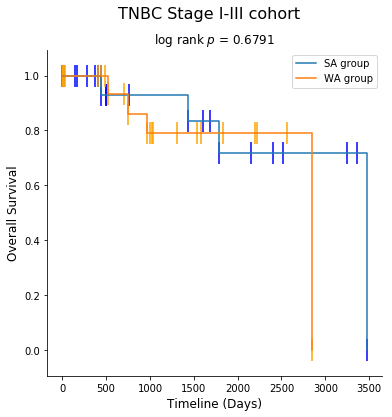

In [12]:
time,event = "OS.time", "OS"
plot_title = 'TNBC Stage I-III cohort'
x_label = 'Timeline (Days)'
y_label = 'Overall Survival'
sliceDf = survival_Df_III[survival_Df_III[time]<8000]
plotsurvival(sliceDf.dropna(subset=[time,event]),"cluster",time,event,plot_title, x_label, y_label)

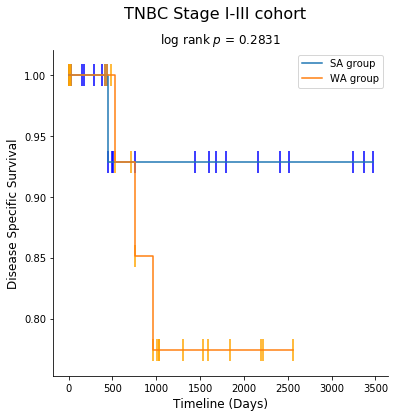

In [13]:
time,event = "DSS.time", "DSS"
plot_title = 'TNBC Stage I-III cohort'
x_label = 'Timeline (Days)'
y_label = 'Disease Specific Survival'
sliceDf = survival_Df_III[survival_Df_III[time]<8000]
plotsurvival(sliceDf.dropna(subset=[time,event]),"cluster",time,event,plot_title, x_label, y_label)

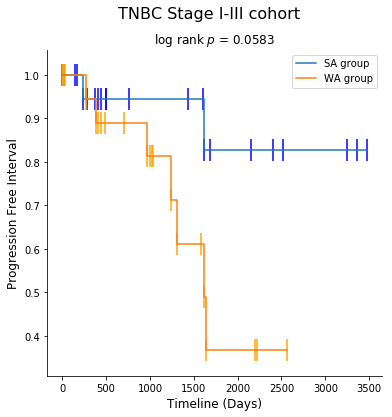

In [14]:
time,event = "PFI.time", "PFI"
plot_title = 'TNBC Stage I-III cohort'
x_label = 'Timeline (Days)'
y_label = 'Progression Free Interval'
sliceDf = survival_Df_III[survival_Df_III[time]<8000]
plotsurvival(sliceDf.dropna(subset=[time,event]),"cluster",time,event,plot_title, x_label, y_label)

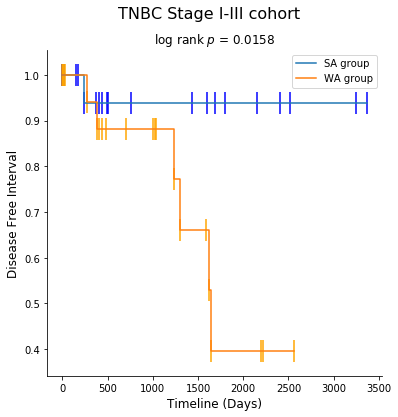

In [15]:
time,event = "DFI.time", "DFI"
plot_title = 'TNBC Stage I-III cohort'
x_label = 'Timeline (Days)'
y_label = 'Disease Free Interval'
sliceDf = survival_Df_III[survival_Df_III[time]<8000]
plotsurvival(sliceDf.dropna(subset=[time,event]),"cluster",time,event,plot_title, x_label, y_label)